# Dissecting Spotify Valence Assignment


In this assignment we will discuss what affects more the varience variable and we will try to predict it using Machine Learning Methods. 


---

> Dimitris Mazarakis, Student <br />
> AM: 8180064  <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> t8180064@aueb.gr

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import random as rn
import os

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [3]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re
from datetime import datetime

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import seaborn as sns

First of all we need to extract some songs from the weekly [Spotify Charts](https://spotifycharts.com/) in order to create our dataset.

The data that we will use is from some countries and the world as a whole, for the period 2017-2019, and is available in Zenodo https://zenodo.org/record/4778563#.YhaxFDWgdPY:

  * Gabriel P. Oliveira, Mariana O. Silva, Danilo B. Seufitelli, Anisio Lacerda, and Mirella M. Moro. Detecting Collaboration Profiles in Success-based Music Genre Networks. In Proceedings of the 21st International Society for Music Information Retrieval Conference (ISMIR 2020), 2020.

In [4]:
header = 0
dfs = []
for file in glob.glob('Charts/*/201?/*.csv'):
    region = file.split('/')[0]
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    weekly_chart['region'] = region
    dfs.append(weekly_chart)

all_charts = pd.concat(dfs)

In [5]:
all_charts

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region
0,1,5aAx2yezTd8zXrkmtKl66Z,Starboy,The Weeknd,947261,NaN,1,1,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
1,2,5knuzwU65gJK7IF5yJsuaW,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,893107,NaN,1,2,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
2,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,871617,NaN,1,3,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
3,4,3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,791592,NaN,1,4,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
4,5,78rIJddV4X0HkNAInEcYde,Call On Me - Ryan Riback Extended Remix,Starley,743490,NaN,1,5,new,2016-12-30,2017-01-06,Charts\au\2017\au-weekly_with_features-2016-12...
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,7f5trao56t7sB7f14QDTmp,Juicy,Doja Cat,1920454,146.0,8,66,-50,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
196,197,5JiH89mHrv9oWHlD0T326z,To Be So Lonely,Harry Styles,1912267,32.0,2,32,-165,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
197,198,7GX5flRQZVHRAGd6B4TmDO,XO Tour Llif3,Lil Uzi Vert,1902239,154.0,121,2,-44,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...
198,199,2dpaYNEQHiRxtZbfNsse99,Happier,Marshmello,1899623,173.0,71,8,-26,2019-12-20,2019-12-27,Charts\us\2019\us-weekly_with_features-2019-12...


From the 273.600 songs only 13.880 are unique

In [6]:
pd.DataFrame(all_charts['song_id'].unique())

,0
0,5aAx2yezTd8zXrkmtKl66Z
1,5knuzwU65gJK7IF5yJsuaW
2,7BKLCZ1jbUBVqRi2FVlTVw
3,3NdDpSvN911VPGivFlV5d0
4,78rIJddV4X0HkNAInEcYde
...,...
13875,3aQV6E290SJvasp2VOgvBz
13876,43YQDj1KOPMFAUcTEPKy4p
13877,1985nAkGJf1oOrgHCWftoN
13878,7ntUbTIwmwOD6ygCMRZT6e


In [7]:
len(all_charts['song_id'].unique())

13880

In [8]:
client_credentials_manager = SpotifyClientCredentials('0d943913b22349d0946d5d7ae5169277',
                                                      'a8f7e74e8e304591aa00d569f2e54e37')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [9]:
features = {}
all_track_ids = list(all_charts['song_id'].unique())

We now use Spotify's API to extract audio features for every track id

In [10]:
start = 0
num_tracks = 100
while start < len(all_track_ids):
    #print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

In [11]:
some_tracks = pd.DataFrame.from_dict(features, orient='index')

In [12]:
some_tracks = some_tracks.reset_index().rename(columns={'index' : 'song_id'})
some_tracks

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7,-7.028,1,0.2820,0.16500,0.000003,0.1340,0.5350,186.054,audio_features,5aAx2yezTd8zXrkmtKl66Z,spotify:track:5aAx2yezTd8zXrkmtKl66Z,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,https://api.spotify.com/v1/audio-analysis/5aAx...,230453,4
1,5knuzwU65gJK7IF5yJsuaW,0.720,0.763,9,-4.068,0,0.0523,0.40600,0.000000,0.1800,0.7420,101.965,audio_features,5knuzwU65gJK7IF5yJsuaW,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
2,7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8,-5.599,1,0.0338,0.41400,0.000000,0.1110,0.6610,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
3,3NdDpSvN911VPGivFlV5d0,0.735,0.451,0,-8.374,1,0.0585,0.06310,0.000013,0.3250,0.0862,117.973,audio_features,3NdDpSvN911VPGivFlV5d0,spotify:track:3NdDpSvN911VPGivFlV5d0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,https://api.spotify.com/v1/audio-analysis/3NdD...,245200,4
4,78rIJddV4X0HkNAInEcYde,0.670,0.838,0,-4.031,1,0.0362,0.06040,0.000611,0.1590,0.7170,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13875,3aQV6E290SJvasp2VOgvBz,0.810,0.690,10,-7.841,0,0.2700,0.03730,0.000000,0.1060,0.6180,139.970,audio_features,3aQV6E290SJvasp2VOgvBz,spotify:track:3aQV6E290SJvasp2VOgvBz,https://api.spotify.com/v1/tracks/3aQV6E290SJv...,https://api.spotify.com/v1/audio-analysis/3aQV...,140369,4
13876,43YQDj1KOPMFAUcTEPKy4p,0.942,0.531,1,-7.510,1,0.2150,0.00236,0.000106,0.0812,0.7400,99.027,audio_features,43YQDj1KOPMFAUcTEPKy4p,spotify:track:43YQDj1KOPMFAUcTEPKy4p,https://api.spotify.com/v1/tracks/43YQDj1KOPMF...,https://api.spotify.com/v1/audio-analysis/43YQ...,157520,4
13877,1985nAkGJf1oOrgHCWftoN,0.762,0.679,4,-7.595,0,0.1920,0.04260,0.000000,0.1860,0.3280,150.051,audio_features,1985nAkGJf1oOrgHCWftoN,spotify:track:1985nAkGJf1oOrgHCWftoN,https://api.spotify.com/v1/tracks/1985nAkGJf1o...,https://api.spotify.com/v1/audio-analysis/1985...,125320,4
13878,7ntUbTIwmwOD6ygCMRZT6e,0.774,0.836,9,-2.323,0,0.1520,0.28800,0.000024,0.0824,0.4940,112.014,audio_features,7ntUbTIwmwOD6ygCMRZT6e,spotify:track:7ntUbTIwmwOD6ygCMRZT6e,https://api.spotify.com/v1/tracks/7ntUbTIwmwOD...,https://api.spotify.com/v1/audio-analysis/7ntU...,201271,4


And we will drop all unnecessary columns

In [13]:
some_tracks = some_tracks.drop(['id','uri','track_href','analysis_url','time_signature','type'],axis = 1)

In [14]:
some_tracks

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7,-7.028,1,0.2820,0.16500,0.000003,0.1340,0.5350,186.054,230453
1,5knuzwU65gJK7IF5yJsuaW,0.720,0.763,9,-4.068,0,0.0523,0.40600,0.000000,0.1800,0.7420,101.965,251088
2,7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8,-5.599,1,0.0338,0.41400,0.000000,0.1110,0.6610,95.010,244960
3,3NdDpSvN911VPGivFlV5d0,0.735,0.451,0,-8.374,1,0.0585,0.06310,0.000013,0.3250,0.0862,117.973,245200
4,78rIJddV4X0HkNAInEcYde,0.670,0.838,0,-4.031,1,0.0362,0.06040,0.000611,0.1590,0.7170,104.998,222041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13875,3aQV6E290SJvasp2VOgvBz,0.810,0.690,10,-7.841,0,0.2700,0.03730,0.000000,0.1060,0.6180,139.970,140369
13876,43YQDj1KOPMFAUcTEPKy4p,0.942,0.531,1,-7.510,1,0.2150,0.00236,0.000106,0.0812,0.7400,99.027,157520
13877,1985nAkGJf1oOrgHCWftoN,0.762,0.679,4,-7.595,0,0.1920,0.04260,0.000000,0.1860,0.3280,150.051,125320
13878,7ntUbTIwmwOD6ygCMRZT6e,0.774,0.836,9,-2.323,0,0.1520,0.28800,0.000024,0.0824,0.4940,112.014,201271


Here we use another data source to add more songs to out dataset.
The data source is from: https://www.kaggle.com/mrmorj/dataset-of-songs-in-spotify


In [15]:
data_filename = "more_songs_kaggle.csv"

more_songs = pd.read_csv(data_filename, sep=",")

C:\Users\dimit\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
more_songs

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,...,46bXU7Sgj7104ZoXxzz9tM,spotify:track:46bXU7Sgj7104ZoXxzz9tM,https://api.spotify.com/v1/tracks/46bXU7Sgj710...,https://api.spotify.com/v1/audio-analysis/46bX...,269208,4,hardstyle,NaN,20995.0,Euphoric Hardstyle
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,...,0he2ViGMUO3ajKTxLOfWVT,spotify:track:0he2ViGMUO3ajKTxLOfWVT,https://api.spotify.com/v1/tracks/0he2ViGMUO3a...,https://api.spotify.com/v1/audio-analysis/0he2...,210112,4,hardstyle,NaN,20996.0,Greatest Hardstyle Playlist
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,...,72DAt9Lbpy9EUS29OzQLob,spotify:track:72DAt9Lbpy9EUS29OzQLob,https://api.spotify.com/v1/tracks/72DAt9Lbpy9E...,https://api.spotify.com/v1/audio-analysis/72DA...,234823,4,hardstyle,NaN,20997.0,Best of Hardstyle 2020
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,...,6HXgExFVuE1c3cq9QjFCcU,spotify:track:6HXgExFVuE1c3cq9QjFCcU,https://api.spotify.com/v1/tracks/6HXgExFVuE1c...,https://api.spotify.com/v1/audio-analysis/6HXg...,323200,4,hardstyle,NaN,20998.0,Euphoric Hardstyle


We have 35.877 unique songs from this data source

In [17]:
pd.DataFrame(more_songs.id.unique())

,0
0,2Vc6NJ9PW9gD9q343XFRKx
1,7pgJBLVz5VmnL7uGHmRj6p
2,0vSWgAlfpye0WCGeNmuNhy
3,0VSXnJqQkwuH2ei1nOQ1nu
4,4jCeguq9rMTlbMmPHuO7S3
...,...
35872,4PMqy2vJjmv6ydGVqtCqPW
35873,46bXU7Sgj7104ZoXxzz9tM
35874,72DAt9Lbpy9EUS29OzQLob
35875,6HXgExFVuE1c3cq9QjFCcU


In [18]:
more_songs = more_songs.drop_duplicates(subset=['id'])

Changing the order of the columns

In [19]:
column_names = ['id', 'danceability', 'energy', 'key', 'mode', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']


more_songs = more_songs.reindex(columns=column_names)

Changing the song id column name

In [20]:
more_songs.columns = ['song_id', 'danceability', 'energy', 'key', 'mode', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']
more_songs

,song_id,danceability,energy,key,mode,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2Vc6NJ9PW9gD9q343XFRKx,0.831,0.814,2,1,-7.364,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539
1,7pgJBLVz5VmnL7uGHmRj6p,0.719,0.493,8,1,-7.230,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427
2,0vSWgAlfpye0WCGeNmuNhy,0.850,0.893,5,1,-4.783,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821
3,0VSXnJqQkwuH2ei1nOQ1nu,0.476,0.781,0,1,-4.710,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661
4,4jCeguq9rMTlbMmPHuO7S3,0.798,0.624,2,1,-7.668,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42298,4PMqy2vJjmv6ydGVqtCqPW,0.502,0.991,5,0,-4.333,0.2400,0.005540,0.000198,0.4700,0.0797,150.029,200000
42300,46bXU7Sgj7104ZoXxzz9tM,0.528,0.693,4,1,-5.148,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208
42302,72DAt9Lbpy9EUS29OzQLob,0.361,0.821,8,1,-3.102,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823
42303,6HXgExFVuE1c3cq9QjFCcU,0.477,0.921,6,0,-4.777,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200


In [21]:
frames = [some_tracks,more_songs]
tracks = pd.concat(frames)

In [22]:
tracks

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7,-7.028,1,0.2820,0.165000,0.000003,0.1340,0.5350,186.054,230453
1,5knuzwU65gJK7IF5yJsuaW,0.720,0.763,9,-4.068,0,0.0523,0.406000,0.000000,0.1800,0.7420,101.965,251088
2,7BKLCZ1jbUBVqRi2FVlTVw,0.748,0.524,8,-5.599,1,0.0338,0.414000,0.000000,0.1110,0.6610,95.010,244960
3,3NdDpSvN911VPGivFlV5d0,0.735,0.451,0,-8.374,1,0.0585,0.063100,0.000013,0.3250,0.0862,117.973,245200
4,78rIJddV4X0HkNAInEcYde,0.670,0.838,0,-4.031,1,0.0362,0.060400,0.000611,0.1590,0.7170,104.998,222041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42298,4PMqy2vJjmv6ydGVqtCqPW,0.502,0.991,5,-4.333,0,0.2400,0.005540,0.000198,0.4700,0.0797,150.029,200000
42300,46bXU7Sgj7104ZoXxzz9tM,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208
42302,72DAt9Lbpy9EUS29OzQLob,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823
42303,6HXgExFVuE1c3cq9QjFCcU,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200


We can see that we have common songs between the two datasets so we have to drop them

In [23]:
pd.DataFrame(tracks.song_id.unique())

,0
0,5aAx2yezTd8zXrkmtKl66Z
1,5knuzwU65gJK7IF5yJsuaW
2,7BKLCZ1jbUBVqRi2FVlTVw
3,3NdDpSvN911VPGivFlV5d0
4,78rIJddV4X0HkNAInEcYde
...,...
48378,4PMqy2vJjmv6ydGVqtCqPW
48379,46bXU7Sgj7104ZoXxzz9tM
48380,72DAt9Lbpy9EUS29OzQLob
48381,6HXgExFVuE1c3cq9QjFCcU


In [24]:
tracks = tracks.drop_duplicates(subset=['song_id'])

So now our dataset will contain 48.383 songs.

Now we need to read the validation dataset with which we will test our models

In [26]:
data_filename = "spotify_ids.txt"

validation_dataset = pd.read_csv(data_filename, sep=" ")

In [27]:
validation_dataset.columns = ['song_id']
validation_dataset

,song_id
0,5QO79kh1waicV47BqGRL3g
1,0VjIjW4GlUZAMYd2vXMi3b
2,4MzXwWMhyBbmu6hOcLVD49
3,5Kskr9LcNYa0tpt5f0ZEJx
4,6tDDoYIxWvMLTdKpjFkc1B
...,...
1156,4lUmnwRybYH7mMzf16xB0y
1157,1fzf9Aad4y1RWrmwosAK5y
1158,3E3pb3qH11iny6TFDJvsg5
1159,3yTkoTuiKRGL2VAlQd7xsC


We will need to extract the audio feutures for the validation songs by using the Spotify's API

In [28]:
features = {}
validation_dataset_track_ids = list(validation_dataset['song_id'].unique())

In [29]:
start = 0
num_tracks = 100
while start < len(validation_dataset_track_ids):
    #print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = validation_dataset_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

In [30]:

validation_dataset = pd.DataFrame.from_dict(features, orient='index')

validation_dataset = validation_dataset.reset_index().rename(columns={'index' : 'song_id'})

validation_dataset = validation_dataset.drop(['id','uri','track_href','analysis_url','key','mode','time_signature'],axis = 1)

Now we need to check if there are same songs in validation and the training dataset and there are

In [31]:
np.intersect1d(validation_dataset.song_id, np.intersect1d(validation_dataset.song_id, tracks.song_id))

array(['017PF4Q3l4DBUiWoXk4OWT', '0247StOpd3AkeBQzANX4Zf',
       '09mEdoA6zrmBPgTEN5qXmN', '0B7wvvmu9EISAwZnOpjhNI',
       '0JP9xo3adEtGSdUEISiszL', '0PvFJmanyNQMseIFrU708S',
       '0RiRZpuVRbi7oqRdSMwhQY', '0bYg9bo50gSsH3LtXe2SQn',
       '0ct6r3EGTcMLPtrXHDvVjc', '0e7ipj03S05BNilyu5bRzt',
       '0fea68AdmYNygeTGI4RC18', '0hVXuCcriWRGvwMV1r5Yn9',
       '0lLdorYw7lVrJydTINhWdI', '0lizgQ7Qw35od7CYaoMBZb',
       '0nbXyq5TXYPCO7pr3N8S4I', '0ofHAoxe9vBkTCp2UQIavz',
       '0pqnGHJpmpxLKifKRmU6WP', '0qOnSQQF0yzuPWsXrQ9paz',
       '0tXPhc8LvM4dPvoRwI66XQ', '0tgVpDi06FyKpA1z0VMD4v',
       '0u2P5u6lvoDfwTYjAADbn4', '161DnLWsx1i3u1JT05lzqU',
       '1BKT2I9x4RGKaKqW4up34s', '1Cv1YLb4q0RzL6pybtaMLo',
       '1H7KnK26kc1YyellpbINEn', '1IcR6RlgvDczfvoWJSSY2A',
       '1JSTJqkT5qHq8MDJnJbRE1', '1Qi2wh8fFgDV7tl4Sj3f2K',
       '1Slwb6dOYkBlWal1PGtnNg', '1VLtjHwRWOVJiE5Py7JxoQ',
       '1VuAamHM7P3VQQEXYGG3Uu', '1XGmzt0PVuFgQYYnV2It7A',
       '1ZMiCix7XSAbfAJlEZWMCp', '1f3yAtsJtY87CTmM8RLnxf

In [32]:
cond = tracks['song_id'].isin(validation_dataset['song_id'])
tracks.drop(tracks[cond].index, inplace = True)
tracks

C:\Users\dimit\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7,-7.028,1,0.2820,0.165000,0.000003,0.1340,0.5350,186.054,230453
1,5knuzwU65gJK7IF5yJsuaW,0.720,0.763,9,-4.068,0,0.0523,0.406000,0.000000,0.1800,0.7420,101.965,251088
3,3NdDpSvN911VPGivFlV5d0,0.735,0.451,0,-8.374,1,0.0585,0.063100,0.000013,0.3250,0.0862,117.973,245200
4,78rIJddV4X0HkNAInEcYde,0.670,0.838,0,-4.031,1,0.0362,0.060400,0.000611,0.1590,0.7170,104.998,222041
6,3AsAuGTaDQzavZZThyYlop,0.803,0.569,2,-7.392,1,0.0739,0.062300,0.000000,0.0830,0.8090,107.986,188889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42298,4PMqy2vJjmv6ydGVqtCqPW,0.502,0.991,5,-4.333,0,0.2400,0.005540,0.000198,0.4700,0.0797,150.029,200000
42300,46bXU7Sgj7104ZoXxzz9tM,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208
42302,72DAt9Lbpy9EUS29OzQLob,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823
42303,6HXgExFVuE1c3cq9QjFCcU,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200


And we can see that the test dataset and the training dataset does not have common songs

In [33]:
np.intersect1d(validation_dataset.song_id, np.intersect1d(validation_dataset.song_id, tracks.song_id))

array([], dtype=object)

We need to split our validation dataset to the dependent and the independent variables

In [34]:
independent_val = validation_dataset[validation_dataset.columns.difference(["song_id","type",'valence','time_signature'])]
dependent_val = pd.DataFrame(validation_dataset['valence'])
idependent_plus_dependent_val = validation_dataset[validation_dataset.columns.difference(["song_id","type",'time_signature'])]

# Q1

First we check for null value and there aren't.

In [35]:
tracks.isna().sum()

song_id             0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64

In [36]:
tracks

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,5aAx2yezTd8zXrkmtKl66Z,0.681,0.594,7,-7.028,1,0.2820,0.165000,0.000003,0.1340,0.5350,186.054,230453
1,5knuzwU65gJK7IF5yJsuaW,0.720,0.763,9,-4.068,0,0.0523,0.406000,0.000000,0.1800,0.7420,101.965,251088
3,3NdDpSvN911VPGivFlV5d0,0.735,0.451,0,-8.374,1,0.0585,0.063100,0.000013,0.3250,0.0862,117.973,245200
4,78rIJddV4X0HkNAInEcYde,0.670,0.838,0,-4.031,1,0.0362,0.060400,0.000611,0.1590,0.7170,104.998,222041
6,3AsAuGTaDQzavZZThyYlop,0.803,0.569,2,-7.392,1,0.0739,0.062300,0.000000,0.0830,0.8090,107.986,188889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42298,4PMqy2vJjmv6ydGVqtCqPW,0.502,0.991,5,-4.333,0,0.2400,0.005540,0.000198,0.4700,0.0797,150.029,200000
42300,46bXU7Sgj7104ZoXxzz9tM,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208
42302,72DAt9Lbpy9EUS29OzQLob,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823
42303,6HXgExFVuE1c3cq9QjFCcU,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200


We also converted key and mode columns to dummies because they are categorical but they do not seem to give that much information to the model

In [37]:
'''tracks = pd.get_dummies(tracks, columns=['key'])
tracks = pd.get_dummies(tracks, columns=['mode'])'''

"tracks = pd.get_dummies(tracks, columns=['key'])\ntracks = pd.get_dummies(tracks, columns=['mode'])"

So we will drop those two columns

In [38]:
tracks = tracks.drop(['key','mode'],axis = 1)

In [39]:
independent = tracks[tracks.columns.difference(["song_id",'valence','time_signature',])]
dependent = pd.DataFrame(tracks['valence'])  
idependent_plus_dependent = tracks[tracks.columns.difference(["song_id",'time_signature'])]

We also try scaling the data to compare the results

In [40]:
from sklearn.preprocessing import StandardScaler

We also scaled the data and test them but the results is not so different

In [41]:
scaler = StandardScaler()
scaler.fit(idependent_plus_dependent)
sc = scaler.transform(idependent_plus_dependent)
scaled_tracks = pd.DataFrame(sc, index=idependent_plus_dependent.index, columns=idependent_plus_dependent.columns)
scaled_tracks

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.138664,0.219736,-0.127502,-0.797791,-0.633992,-0.421459,-0.195236,1.128521,1.652830,0.589066
1,1.334472,0.473244,0.088812,0.128175,-0.634002,-0.153317,0.849849,-0.681198,-1.408440,1.460779
3,-0.366950,0.570748,0.027089,-1.581301,-0.633965,0.691912,-0.670468,-0.632351,-0.825667,-1.300908
4,-0.380347,0.148233,-0.215684,0.539106,-0.632250,-0.275730,0.862912,-0.808044,-1.298024,1.355499
6,-0.370919,1.012763,-0.563211,-0.934768,-0.634002,-0.718746,-0.323754,-0.511020,-1.189245,1.742927
...,...,...,...,...,...,...,...,...,...,...
42298,-0.652554,-0.943804,-0.446736,1.377407,-0.633435,1.537141,0.756286,0.797619,0.341335,-1.328280
42300,-0.523744,-0.774799,0.278761,-0.255361,-0.633013,-0.497238,0.468534,-0.853740,0.340753,-0.004709
42302,-0.551035,-1.860336,-0.081692,0.445962,-0.633308,1.041662,1.190914,-0.695380,0.519939,-1.141725
42303,-0.677309,-1.106310,0.844751,0.993871,-0.549121,-0.867390,0.599523,-0.784408,0.341808,0.391141


In [42]:
independent_scaled = scaled_tracks[scaled_tracks.columns.difference(["song_id",'valence','time_signature'])]
dependent_scaled = pd.DataFrame(scaled_tracks['valence'])
idependent_plus_dependent_scaled = scaled_tracks[scaled_tracks.columns.difference(["song_id",'time_signature'])]

## Regression


Firstly we need to find how many and which variables we need to add to our model in order to maximize R squared.

In [43]:
def process_subset(y, data, feature_set):
    X = data.loc[:, feature_set].values
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

def backward_remove_variable(data, exog, selected):
    
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in selected:
        new_selected = selected[:]
        new_selected.remove(column)
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

def backward_stepwise_selection(data, exog):
    
    best_models = []
    selected = [ x for x in data.columns if x != exog ]

    p = len(selected) + 1

    print(f'Finding the best model for {p - 1} variables')
    print(selected)
    y = data.loc[:, exog]
    best_model = process_subset(y, data, selected)
    best_models.append(best_model)

    for i in reversed(range(2, p)):
        print(f'Finding the best model for {i - 1} variable{"s" if (i - 1) > 1 else ""}')
        model, best_column = backward_remove_variable(data, exog, selected)
        selected.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        print(selected)
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [44]:
best_model_audio_features, _ = backward_stepwise_selection(idependent_plus_dependent, 'valence')
print('Best overall model:', len(best_model_audio_features.model.exog_names), best_model_audio_features.model.exog_names)

Finding the best model for 9 variables
['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']
Finding the best model for 8 variables
['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness']
Finding the best model for 7 variables
['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness']
Finding the best model for 6 variables
['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'loudness']
Finding the best model for 5 variables
['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness']
Finding the best model for 4 variables
['acousticness', 'danceability', 'energy', 'instrumentalness']
Finding the best model for 3 variables
['danceability', 'energy', 'instrumentalness']
Finding the best model for 2 variables
['danceability', 'instrumentalness']
Finding the best model for 1

So we will use all the variables.

In [45]:
best_model_audio_features.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2328.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:09:57   Log-Likelihood:                 8775.5
No. Observations:               48066   AIC:                        -1.753e+04
Df Residuals:                   48057   BIC:                        -1.745e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.2242      0.010    -22.754      0.000      -0.244      -0.205
acousticness         0.2112      0.005     39.093      0.000       0.201       0.222
danceability         0.6085      0.006     95.153      0.000       0.596       0.621
duration_ms      -1.774e-07   1.23e-08    -14.388      0.000   -2.02e-07   -1.53e-07
energy               0.3838      0.008     46.467      0.000       0.368       0.400
instrumentalness    -0.1890      0.004    -50.132      0.000      -0.196      -0.182
liveness             0.0095      0.006      1.694      0.090      -0.001       0.020
loudness             0.0009      0.000      1.883      0.060   -3.64e-05       0.002
speechiness          0.0094      0.008      1.197      0.231      -0.006       0.025
==============================================================================
Omnibus:                     1132.553   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              951.428
Skew:                           0.278   Prob(JB):                    2.51e-207
Kurtosis:                       2.592   Cond. No.                     3.65e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.65e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
tracks.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,48066.000000,48066.000000,48066.000000,48066.000000,48066.000000,48066.000000,48066.000000,48066.000000,48066.000000,4.806600e+04
mean,0.647196,0.739607,-6.475031,0.138762,0.137054,0.221091,0.206302,0.395118,140.652980,2.426159e+05
std,0.153842,0.182514,2.832334,0.126927,0.201539,0.348726,0.171553,0.237466,27.468951,9.539488e+04
min,0.065100,0.000243,-34.475000,0.022700,0.000001,0.000000,0.010700,0.018700,46.489000,2.560000e+04
25%,0.536000,0.613000,-8.025000,0.048700,0.003460,0.000000,0.098300,0.194000,124.993000,1.808000e+05
50%,0.657000,0.763000,-6.191500,0.078100,0.037700,0.000110,0.131000,0.371000,139.950000,2.174315e+05
75%,0.769000,0.897000,-4.613000,0.202000,0.191000,0.470000,0.274000,0.572000,155.056000,2.760000e+05
max,0.988000,1.000000,3.148000,0.966000,0.993000,0.989000,0.990000,0.988000,220.290000,1.109080e+06


Now we will try to extract and the audio analysis features to see if they will give us more insights. Unfortunately the Spotify's API does not allow to fetch many audio analysis feature at once like audio features so it takes a lot of to time to fetch song's data so I will take a only 2% sample of the data in order to run faster.

In [47]:
sample_tracks = tracks.sample(frac=0.02, replace=True, random_state=1)
sample_tracks

,song_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
24718,0lXDkLsvRrlMYCHVJDwdfJ,0.647,0.956,-11.049,0.0804,0.095400,0.951000,0.1120,0.0709,140.004,411429
12317,1RGmoxDK77rPBGUNQbHKLW,0.635,0.806,-6.066,0.0990,0.006910,0.000000,0.3520,0.7470,140.032,222280
5318,36qA0yKr7uNfQDFledNkiN,0.396,0.278,-11.472,0.0346,0.881000,0.018300,0.1140,0.2290,155.328,195372
24054,7L1uJvuJnJvvT2k4Dyt6kP,0.795,0.833,-7.436,0.1140,0.000267,0.492000,0.1050,0.7920,124.988,201600
36932,63luHD6mjFZmo8jzUG5Rj9,0.637,0.786,-8.047,0.0406,0.021900,0.487000,0.0917,0.2350,170.007,251820
...,...,...,...,...,...,...,...,...,...,...,...
5421,4M3xIXqnGGmiXkcNTi3HGw,0.454,0.802,-5.318,0.3490,0.131000,0.000000,0.7880,0.6730,185.680,160200
16731,6eipQrmTw1N3nUfgLlEa2R,0.599,0.431,-8.039,0.0413,0.416000,0.000000,0.1040,0.3870,167.368,233493
17946,3t844ssjXzE9M3SDtUxTI4,0.448,0.406,-11.420,0.0483,0.791000,0.002310,0.1120,0.0504,147.912,210640
18626,3ENXjRhFPkH8YSH3qBXTfQ,0.882,0.874,-4.518,0.1410,0.017300,0.000002,0.1520,0.8420,107.880,227933


In [48]:
feature_analysis = {}

for id in sample_tracks['song_id']:
    track_analysis = sp.audio_analysis(id)
    feature_analysis.update({ id : track_analysis })
len(feature_analysis)

944

Here we delete all the string attributes from the dictionary which are not necessary fro our model.

In [49]:
for song in feature_analysis:
	del  feature_analysis[song]['track']['codestring']
	del  feature_analysis[song]['track']['echoprintstring']
	del  feature_analysis[song]['track']['synchstring']
	del  feature_analysis[song]['track']['rhythmstring']
	del  feature_analysis[song]['meta']
	del  feature_analysis[song]['bars']
	del  feature_analysis[song]['beats']
	del  feature_analysis[song]['sections']
	del  feature_analysis[song]['segments']
	del  feature_analysis[song]['tatums']

Here we save in a new dictionary only the track segment from the audio analysis dictionary

In [50]:
only_track_analysis = {}

for song in feature_analysis:
    only_track_analysis.update( { song : feature_analysis[song]['track']})

And we save the dictionary to a dataframe.

In [51]:
tracks_analysis_only = pd.DataFrame.from_dict(only_track_analysis, orient='index')

We drop unnecessary columns because there are on the tracks dataset.

In [52]:
tracks_analysis_only = tracks_analysis_only.drop(['duration','sample_md5',
'offset_seconds','window_seconds','analysis_channels','time_signature','tempo','loudness','num_samples'],axis = 1)

In [53]:
tracks_analysis_only = tracks_analysis_only.reset_index().rename(columns={'index' : 'song_id'})
tracks_analysis_only

,song_id,analysis_sample_rate,end_of_fade_in,start_of_fade_out,tempo_confidence,time_signature_confidence,key,key_confidence,mode,mode_confidence,code_version,echoprint_version,synch_version,rhythm_version
0,0lXDkLsvRrlMYCHVJDwdfJ,22050,0.00000,396.59683,0.745,0.998,11,0.805,1,0.491,3.15,4.12,1.0,1.0
1,1RGmoxDK77rPBGUNQbHKLW,22050,0.67964,217.34457,0.934,1.000,7,0.721,1,0.793,3.15,4.12,1.0,1.0
2,36qA0yKr7uNfQDFledNkiN,22050,0.11197,183.24608,0.087,0.818,0,0.000,1,0.000,3.15,4.12,1.0,1.0
3,7L1uJvuJnJvvT2k4Dyt6kP,22050,0.00000,198.50739,0.859,0.995,0,0.879,1,0.646,3.15,4.12,1.0,1.0
4,63luHD6mjFZmo8jzUG5Rj9,22050,0.09868,236.28625,0.399,0.711,7,0.441,1,0.648,3.15,4.12,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,4M3xIXqnGGmiXkcNTi3HGw,22050,0.20907,154.34303,0.037,1.000,7,0.444,1,0.509,3.15,4.12,1.0,1.0
940,6eipQrmTw1N3nUfgLlEa2R,22050,0.00000,216.25323,0.153,1.000,2,0.453,0,0.534,3.15,4.12,1.0,1.0
941,3t844ssjXzE9M3SDtUxTI4,22050,0.00000,204.72453,0.561,0.993,2,0.859,1,0.826,3.15,4.12,1.0,1.0
942,3ENXjRhFPkH8YSH3qBXTfQ,22050,0.08844,218.59846,0.911,1.000,6,0.978,1,0.651,3.15,4.12,1.0,1.0


And here we save the dataframe to a csv file in order to not have to use API spotify for audio analysis feutures.

In [54]:
'''tracks_analysis_only.to_csv('audio_analysis_tracks.csv',index=False)'''

"tracks_analysis_only.to_csv('audio_analysis_tracks.csv',index=False)"

In [55]:
'''data_filename = "audio_analysis_tracks.csv"

tracks_analysis_only = pd.read_csv(data_filename, sep=",")'''

'data_filename = "audio_analysis_tracks.csv"\n\ntracks_analysis_only = pd.read_csv(data_filename, sep=",")'

Now we need to merge the two dataframes with the audio feutures and the audio analysis.

In [56]:
all_features = pd.merge(tracks, tracks_analysis_only, on='song_id')

In [57]:
all_features.isna().sum()

song_id                      0
danceability                 0
energy                       0
loudness                     0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
duration_ms                  0
analysis_sample_rate         0
end_of_fade_in               0
start_of_fade_out            0
tempo_confidence             0
time_signature_confidence    0
key                          0
key_confidence               0
mode                         0
mode_confidence              0
code_version                 0
echoprint_version            0
synch_version                0
rhythm_version               0
dtype: int64

Here we run a Regression model with all the variables of audio feutures and audio analysis.

First we again need to find which variables we need to add to our model.

In [58]:
all_features = all_features.drop(['code_version','echoprint_version'],axis = 1)

In [59]:
independent_and_analysis = all_features[all_features.columns.difference(["song_id",'valence','duration_ms','analysis_sample_rate'])]
dependent_and_analysis = pd.DataFrame(tracks['valence'])  
idependent_plus_dependent_and_analysis = all_features[all_features.columns.difference(["song_id",'duration_ms','analysis_sample_rate'])]

In [60]:
'''scaler = StandardScaler()
scaler.fit(idependent_plus_dependent_and_analysis)
sc = scaler.transform(idependent_plus_dependent_and_analysis)
scaled_tracks_analysis = pd.DataFrame(sc, index=idependent_plus_dependent_and_analysis.index, columns=idependent_plus_dependent_and_analysis.columns)
scaled_tracks_analysis'''

'scaler = StandardScaler()\nscaler.fit(idependent_plus_dependent_and_analysis)\nsc = scaler.transform(idependent_plus_dependent_and_analysis)\nscaled_tracks_analysis = pd.DataFrame(sc, index=idependent_plus_dependent_and_analysis.index, columns=idependent_plus_dependent_and_analysis.columns)\nscaled_tracks_analysis'

In [61]:
best_model_all_data, _ = backward_stepwise_selection(idependent_plus_dependent_and_analysis, 'valence')
print('Best overall model:', len(best_model_all_data.model.exog_names), best_model_all_data.model.exog_names)

Finding the best model for 18 variables
['acousticness', 'danceability', 'end_of_fade_in', 'energy', 'instrumentalness', 'key', 'key_confidence', 'liveness', 'loudness', 'mode', 'mode_confidence', 'rhythm_version', 'speechiness', 'start_of_fade_out', 'synch_version', 'tempo', 'tempo_confidence', 'time_signature_confidence']
Finding the best model for 17 variables
['acousticness', 'danceability', 'end_of_fade_in', 'energy', 'instrumentalness', 'key', 'key_confidence', 'liveness', 'loudness', 'mode', 'mode_confidence', 'speechiness', 'start_of_fade_out', 'synch_version', 'tempo', 'tempo_confidence', 'time_signature_confidence']
Finding the best model for 16 variables
['acousticness', 'danceability', 'end_of_fade_in', 'energy', 'instrumentalness', 'key', 'key_confidence', 'liveness', 'loudness', 'mode', 'mode_confidence', 'speechiness', 'start_of_fade_out', 'tempo', 'tempo_confidence', 'time_signature_confidence']
Finding the best model for 15 variables
['acousticness', 'danceability', 'e

We can see that the best model is with only 10 variables.

In [62]:
best_model_all_data.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     42.79
Date:                Thu, 24 Feb 2022   Prob (F-statistic):           6.65e-70
Time:                        22:18:04   Log-Likelihood:                 182.49
No. Observations:                 944   AIC:                            -343.0
Df Residuals:                     933   BIC:                            -289.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                    -0.2930      0.075     -3.923      0.000      -0.440      -0.146
acousticness                  0.2342      0.039      5.980      0.000       0.157       0.311
danceability                  0.6284      0.047     13.411      0.000       0.536       0.720
end_of_fade_in               -0.0102      0.004     -2.268      0.024      -0.019      -0.001
energy                        0.4009      0.044      9.049      0.000       0.314       0.488
instrumentalness             -0.1953      0.025     -7.762      0.000      -0.245      -0.146
key                           0.0038      0.002      2.070      0.039       0.000       0.007
mode                         -0.0146      0.014     -1.066      0.287      -0.041       0.012
start_of_fade_out            -0.0002   8.91e-05     -1.790      0.074      -0.000    1.54e-05
tempo                        -0.0003      0.000     -1.191      0.234      -0.001       0.000
time_signature_confidence     0.0751      0.041      1.836      0.067      -0.005       0.155
==============================================================================
Omnibus:                       19.206   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.800
Skew:                           0.289   Prob(JB):                     0.000136
Kurtosis:                       2.655   Cond. No.                     3.76e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.76e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see that the audio analysis attributes does not play such an important role in valence prediction because the Adj. R-squared changed only a little and the the data with audio analysis ara much less from the data with audio features so we are going to use only audio features.

Here we plot the Coefficiencies with 95% confidence intervals of our model.
The code I use to plot the diagram I found it [here](https://medium.com/analytics-vidhya/create-your-own-coefficient-plot-function-in-python-aadb9fe27a77).

In [63]:
# Define function to output plot of the model coefficients

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['intercept'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

C:\Users\dimit\AppData\Local\Temp/ipykernel_11672/4258254443.py:65: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


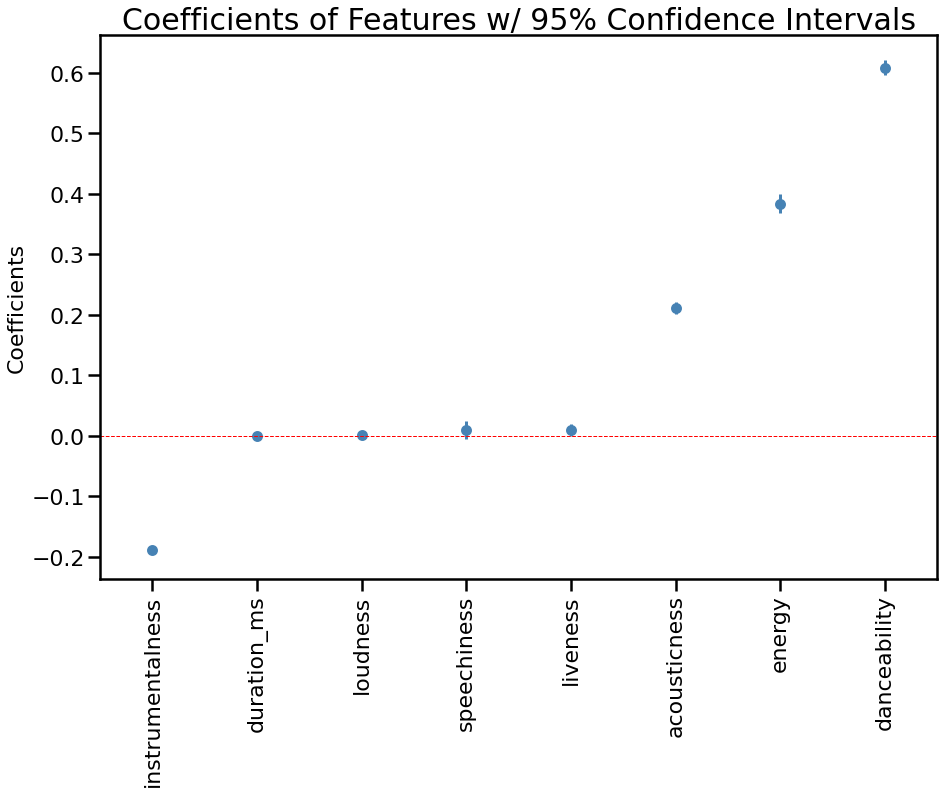

In [64]:
# Plot coefficients w/95% confidence intervals for Model

coefplot(best_model_audio_features)

### We can see that the variable that affects the valence variable more is the danceability.

In [65]:
model = smf.ols('valence ~ danceability', data=tracks)
tracks_res = model.fit()
tracks_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     7211.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:18:05   Log-Likelihood:                 4263.1
No. Observations:               48066   AIC:                            -8522.
Df Residuals:                   48064   BIC:                            -8505.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0343      0.004      7.854      0.000       0.026       0.043
danceability     0.5575      0.007     84.916      0.000       0.545       0.570
==============================================================================
Omnibus:                     2579.727   Durbin-Watson:                   1.455
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1357.911
Skew:                           0.245   Prob(JB):                    1.36e-295
Kurtosis:                       2.338   Cond. No.                         9.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here we check for multicollinearity.

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(independent.iloc[ 0:-1])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
          index=X.columns)

C:\Users\dimit\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const               156.149579
acousticness          1.422859
danceability          1.181453
duration_ms           1.639153
energy                2.689093
instrumentalness      2.045671
liveness              1.090016
loudness              2.100441
speechiness           1.199791
tempo                 1.072960
dtype: float64

Here we check if power the independent variable will make a differnce to our model but it does not.

In [67]:
model = smf.ols('valence ~ np.power(danceability, 2)', data=tracks)
tracks_res = model.fit()
tracks_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     7164.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:18:05   Log-Likelihood:                 4242.7
No. Observations:               48066   AIC:                            -8481.
Df Residuals:                   48064   BIC:                            -8464.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.1998      0.003     79.325      0.000       0.195       0.205
np.power(danceability, 2)     0.4413      0.005     84.639      0.000       0.431       0.452
==============================================================================
Omnibus:                     2467.401   Durbin-Watson:                   1.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1365.592
Skew:                           0.257   Prob(JB):                    2.92e-297
Kurtosis:                       2.354   Cond. No.                         6.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Q2

# Decision Trees

In [68]:
import requests

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

First we need to find the right depth for our tree.

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, KFold

parameters = [
  {'max_depth': list(range(1, 11))},
 ]

cv = KFold(n_splits=5, shuffle=True, random_state=13)
clf = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv)

clf = clf.fit(independent, dependent['valence'])
print(clf.best_estimator_)
print(clf.best_params_)

DecisionTreeRegressor(max_depth=8)
{'max_depth': 8}


The best depth for the tree is 8.

In [70]:
prediction_tree = DecisionTreeRegressor(max_depth=8)

prediction_tree.fit(independent, dependent)

DecisionTreeRegressor(max_depth=8)

In [71]:
'''plt.figure(figsize=(18, 10))
_ = tree.plot_tree(prediction_tree, 
                   feature_names=idependent_plus_dependent.columns[:-1],
                   filled=True, rounded=True, fontsize=14)'''

'plt.figure(figsize=(18, 10))\n_ = tree.plot_tree(prediction_tree, \n                   feature_names=idependent_plus_dependent.columns[:-1],\n                   filled=True, rounded=True, fontsize=14)'

In [72]:
from scipy.stats import sem
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm

In [73]:
# Split the dataset into a training and a testing set
# Test set will be the 20% taken randomly
X_train, X_test, y_train, y_test = train_test_split(independent, dependent['valence'], test_size=0.20, 
                                                    shuffle=True, random_state=33)

In [74]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

In [75]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Forest
We will try RandomForestRegressor.

After running GridSearchCV in order to tune the hyperparameters I saw that cv should be 5 and n_estimators = 500 and min_samples_split = 2

In [76]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 500, max_depth=None, min_samples_split=2, random_state = 42)

rf.fit(X_train, y_train)
scores = rf.score(X_test, y_test)
'''scores = cross_val_score(rf, independent, dependent['valence'], cv=5)'''
scores.mean()

0.4615406335943467

In [77]:
from sklearn.metrics import mean_absolute_error
predicted = rf.predict(X_test)
mean_absolute_error(predicted, y_test)

0.1374321020282921

We will also try ExtraTreesRegressor.

In [78]:
from sklearn.ensemble import ExtraTreesRegressor

extremely_rts = ExtraTreesRegressor(n_estimators = 500, max_depth=None, min_samples_split=2, random_state = 42)

extremely_rts.fit(X_train, y_train)
scores = extremely_rts.score(X_test, y_test)
scores.mean()

0.46368956685430796

In [79]:
predicted = extremely_rts.predict(X_test)
mean_absolute_error(predicted, y_test)

0.1340722727064699

# Boost
Now we will try AdaBoostRegressor.

In [80]:
from sklearn.ensemble import AdaBoostRegressor
rgr = AdaBoostRegressor(prediction_tree, n_estimators=50)
rgr.fit(X_train, y_train)
scores = rgr.score(X_test, y_test)
'''scores = cross_val_score(rgr, X_test, 
                         y_test, cv=5)'''
scores.mean()   

0.322250472686881

In [81]:
from sklearn.metrics import mean_absolute_error
predicted = rgr.predict(X_test)
mean_absolute_error(predicted, y_test)

0.16411087904129212

In [82]:
'''scores = -cross_val_score(rgr, X_test, 
                         y_test, cv=5, )
print(scores.mean())'''

'scores = -cross_val_score(rgr, X_test, \n                         y_test, cv=5, )\nprint(scores.mean())'

# XGboost

In [83]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(n_estimators = 50, max_depth=None)
xgb_reg.fit(X_train, y_train)
scores = xgb_reg.score(X_test, y_test)

In [84]:
'''scores = cross_val_score(xgb_reg, X_test, 
                         y_test, cv=5)
scores.mean() '''

'scores = cross_val_score(xgb_reg, X_test, \n                         y_test, cv=5)\nscores.mean() '

In [85]:
preds = xgb_reg.predict(X_test)
mean_absolute_error(y_test, preds)

0.14585089518298036

In [86]:
'''scores = cross_val_score(xgb_reg, X_test, 
                         y_test, scoring="neg_mean_absolute_error", cv=5)
print(np.mean(-scores))'''

'scores = cross_val_score(xgb_reg, X_test, \n                         y_test, scoring="neg_mean_absolute_error", cv=5)\nprint(np.mean(-scores))'

# LightGBM

In [87]:
import lightgbm as lgb

lgb_reg = lgb.LGBMRegressor(n_estimators = 500, max_depth=None)

In [88]:
lgb_reg.fit(X_train, y_train)
scores = lgb_reg.score(X_test, y_test)
scores.mean()

0.43486982533474805

In [89]:
preds = lgb_reg.predict(X_test)
mean_absolute_error(y_test, preds)

0.1425345398441527

In [90]:
'''scores = cross_val_score(lgb_reg, 
                         independent, 
                         dependent['valence'],
                         scoring="neg_mean_absolute_error", cv=5)
print(-scores)
print(np.mean(-scores))'''

'scores = cross_val_score(lgb_reg, \n                         independent, \n                         dependent[\'valence\'],\n                         scoring="neg_mean_absolute_error", cv=5)\nprint(-scores)\nprint(np.mean(-scores))'

# Voting Ensembles

In [91]:
from sklearn.ensemble import VotingRegressor

xgb_reg = xgb.XGBRegressor()
lgb_reg = lgb.LGBMRegressor(n_estimators = 500, max_depth=None)
vreg = VotingRegressor(estimators=[('xgb', xgb_reg), 
                                   ('lgb', lgb_reg)],
                       n_jobs=-1)
                       
'''scores = cross_val_score(vreg, independent, 
                         dependent['valence'], scoring='neg_median_absolute_error', n_jobs=-1)
print(-scores)
print(np.mean(-scores))'''
vreg.fit(X_train, y_train)
scores = vreg.score(X_test, y_test)
scores.mean()

0.43430542151458784

In [92]:
preds = vreg.predict(X_test)
mean_absolute_error(y_test, preds)

0.14276187671663063

# Stacked Ensembles

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

xgb_reg = xgb.XGBRegressor()
lgb_reg = lgb.LGBMRegressor(n_estimators = 500, max_depth=None)

estimators = [('xgb', xgb_reg), ('lgb', lgb_reg)]
final_estimator = LinearRegression()

sreg = StackingRegressor(estimators=estimators, final_estimator=final_estimator, n_jobs=-1)

'''scores = cross_val_score(sreg, independent, 
                         dependent['valence'],
                         cv=5, scoring='neg_median_absolute_error', n_jobs=-1)
print(-scores)
print(np.mean(-scores))'''
sreg.fit(X_train, y_train)
scores = sreg.score(X_test, y_test)
scores.mean()   

0.43689256540905663

In [94]:
preds = sreg.predict(X_test)
mean_absolute_error(y_test, preds)

0.14270915205725856

### SVR

In [95]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X_train, y_train)
scores = regr.score(X_test, y_test)
scores.mean()  

0.37671241758993

In [96]:
preds = regr.predict(X_test)
mean_absolute_error(y_test, preds)

0.1541339092626777

In [97]:
scores = cross_val_score(regr, X_test, 
                         y_test, cv=5)
scores.mean()

0.35194044953574927

### Stochastic Gradient Descent Classification

In [98]:
from sklearn.linear_model import SGDRegressor

In [99]:
# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [100]:
preds = reg.predict(X_test)
mean_absolute_error(y_test, preds)

0.16471763333830544

In [101]:
scores = reg.score(X_test, y_test)
scores.mean()

0.2826379331184713

After running all the Machine Learning methods we can see that the ExtraTreesRegressor Forest has the best result

In [102]:
importances = extremely_rts.feature_importances_

std = np.std([tree.feature_importances_ for tree in extremely_rts.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

for f in range(independent.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], independent.columns[indices[f]], importances[indices[f]]))

1. feature 4 instrumentalness (0.190268)
2. feature 1 danceability (0.189506)
3. feature 3 energy (0.126166)
4. feature 8 tempo (0.095335)
5. feature 0 acousticness (0.084479)
6. feature 2 duration_ms (0.083667)
7. feature 6 loudness (0.080759)
8. feature 5 liveness (0.075454)
9. feature 7 speechiness (0.074366)


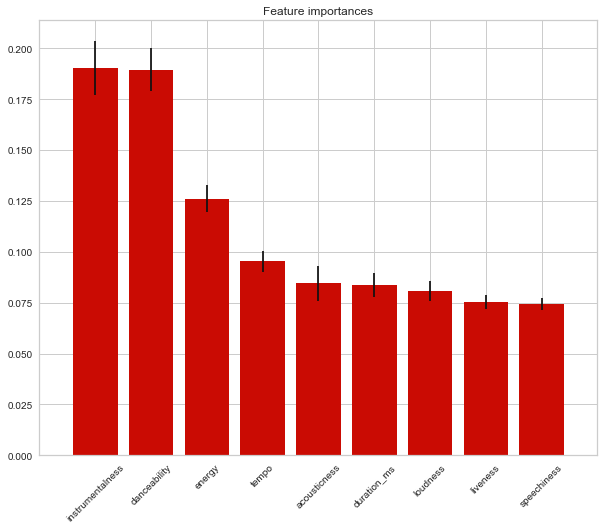

In [103]:
# Plot the feature importances of the forest
plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(independent.shape[1]), importances[indices],
        tick_label=[independent.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
plt.xlim([-1, independent.shape[1]])
_ = plt.xticks(rotation=45)

Here we can see the importance of every variable. We can see that the most important variable is instrumentalness.

# Neural networks

In [104]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

Because the algorithms we will use are probabilistic, we will initialize the random number generators with specific values to ensure reproducibility.

In [105]:
np.random.seed(13)
tf.compat.v1.set_random_seed(13)
rn.seed(12345)

os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [106]:
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
acousticness,38452.0,0.137598,0.201963,0.000001,0.003488,0.037900,0.19200,0.993
danceability,38452.0,0.647468,0.153661,0.065100,0.537000,0.658000,0.76900,0.988
duration_ms,38452.0,242669.814132,95502.565583,25600.000000,180713.000000,217307.000000,275959.75000,1109080.000
energy,38452.0,0.739477,0.183097,0.000243,0.613000,0.763000,0.89800,1.000
instrumentalness,38452.0,0.220246,0.348351,0.000000,0.000000,0.000113,0.46600,0.989
liveness,38452.0,0.206230,0.171373,0.010700,0.098400,0.131000,0.27325,0.990
loudness,38452.0,-6.476194,2.838477,-34.475000,-8.026000,-6.189000,-4.60500,3.148
speechiness,38452.0,0.139182,0.127282,0.023100,0.048900,0.078300,0.20300,0.966
tempo,38452.0,140.630285,27.489365,46.660000,124.993000,139.950000,155.05600,220.290


We can see some big differencies among the feature columns, so we will need to normalize them.

In [107]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))
with np.printoptions(precision=2):
    print(normalizer.mean)
    print(normalizer.variance)
    print(normalizer.count)

tf.Tensor(
[[ 1.38e-01  6.47e-01  2.43e+05  7.39e-01  2.20e-01  2.06e-01 -6.48e+00
   1.39e-01  1.41e+02]], shape=(1, 9), dtype=float32)
tf.Tensor(
[[4.08e-02 2.36e-02 9.12e+09 3.35e-02 1.21e-01 2.94e-02 8.06e+00 1.62e-02
  7.56e+02]], shape=(1, 9), dtype=float32)
<tf.Variable 'count:0' shape=() dtype=int64, numpy=38452>


With this method we build our model

In [108]:
def build_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    return model

### SGD optimizer

In [109]:
sgd = optimizers.SGD()

In [110]:
model = build_model()

In [111]:
model.compile(loss='mean_absolute_error',
              optimizer=sgd)

In [112]:
num_epochs = 50
history = model.fit(X_train, y_train, epochs=num_epochs,
                    validation_split = 0.2, verbose=1)

Epoch 1/50
962/962 [==============================] - 2s 2ms/step - loss: 0.1731 - val_loss: 0.1600
Epoch 2/50
962/962 [==============================] - 1s 2ms/step - loss: 0.1607 - val_loss: 0.1569
Epoch 3/50
962/962 [==============================] - 1s 2ms/step - loss: 0.1581 - val_loss: 0.1558
Epoch 4/50
962/962 [==============================] - 1s 2ms/step - loss: 0.1568 - val_loss: 0.1552
Epoch 5/50
962/962 [==============================] - 1s 2ms/step - loss: 0.1557 - val_loss: 0.1543
Epoch 6/50
962/962 [==============================] - 1s 2ms/step - loss: 0.1549 - val_loss: 0.1544
Epoch 7/50
962/962 [==============================] - 2s 2ms/step - loss: 0.1542 - val_loss: 0.1539
Epoch 8/50
962/962 [==============================] - 1s 1ms/step - loss: 0.1537 - val_loss: 0.1536
Epoch 9/50
962/962 [==============================] - 2s 2ms/step - loss: 0.1532 - val_loss: 0.1581
Epoch 10/50
962/962 [==============================] - 2s 2ms/step - loss: 0.1529 - val_loss: 0.1534

In [113]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,108
Trainable params: 9,089
Non-trainable params: 19
_________________________________________________________________


In [114]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

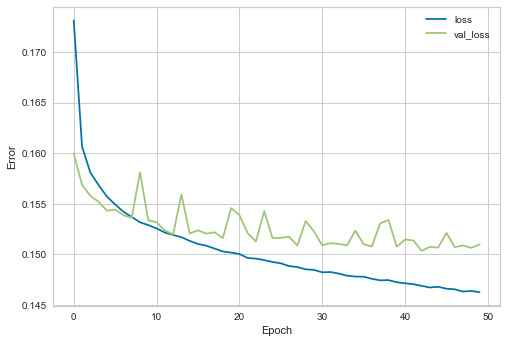

In [115]:
plot_loss(history)

In [116]:
model.evaluate(X_test, y_test, verbose=0)

0.15168234705924988

### 2nd Neural Network with Adam optimizer

With this method we compile our model with Adam optimizer

In [117]:
def compile_model(model):
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

We also use EarlyStopping  to avoid overfitting.

In [118]:
model_adam = build_model()
model_adam = compile_model(model_adam)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
num_epochs = 100
history = model_adam.fit(X_train, y_train, epochs=num_epochs,
                    validation_split = 0.2, verbose=1, 
                    callbacks=[early_stop])

Epoch 1/100
962/962 [==============================] - 3s 2ms/step - loss: 0.1649 - val_loss: 0.1572
Epoch 2/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1566 - val_loss: 0.1566
Epoch 3/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1542 - val_loss: 0.1528
Epoch 4/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1529 - val_loss: 0.1508
Epoch 5/100
962/962 [==============================] - 1s 2ms/step - loss: 0.1518 - val_loss: 0.1502
Epoch 6/100
962/962 [==============================] - 2s 3ms/step - loss: 0.1509 - val_loss: 0.1517
Epoch 7/100
962/962 [==============================] - 3s 3ms/step - loss: 0.1496 - val_loss: 0.1514
Epoch 8/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1492 - val_loss: 0.1495
Epoch 9/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1483 - val_loss: 0.1502
Epoch 10/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1479 - val_lo

In [119]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plot_loss(history)

Now we see the MAE which tells us that we are about 0.15 off our predictions, on average

In [120]:
model_adam.evaluate(X_test, y_test, verbose=0)

0.14962716400623322

We can also add ReduceLROnPlateau callback

In [121]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [122]:
model_adam_red = build_model()
model_adam_red = compile_model(model_adam_red)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
num_epochs = 100
history = model_adam_red.fit(X_train, y_train, epochs=num_epochs,
                    validation_split = 0.2, verbose=1, 
                    callbacks=[reduce_lr,early_stop])

Epoch 1/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1660 - val_loss: 0.1560 - lr: 0.0010
Epoch 2/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1563 - val_loss: 0.1554 - lr: 0.0010
Epoch 3/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1542 - val_loss: 0.1523 - lr: 0.0010
Epoch 4/100
962/962 [==============================] - 1s 2ms/step - loss: 0.1528 - val_loss: 0.1507 - lr: 0.0010
Epoch 5/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1517 - val_loss: 0.1514 - lr: 0.0010
Epoch 6/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1510 - val_loss: 0.1520 - lr: 0.0010
Epoch 7/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1498 - val_loss: 0.1515 - lr: 0.0010
Epoch 8/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1496 - val_loss: 0.1496 - lr: 0.0010
Epoch 9/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1486 - val_

In [123]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plot_loss(history)

In [124]:
model_adam_red.evaluate(X_test, y_test, verbose=0)

0.15041206777095795

We can also add ModelCheckpoint to save the model with the lowest val_loss

In [125]:
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
model_adam_check = build_model()
model_adam_check = compile_model(model_adam_check)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
num_epochs = 100
history = model_adam_check.fit(X_train, y_train, epochs=num_epochs,
                    validation_split = 0.2, verbose=1, 
                    callbacks=[model_checkpoint_callback,early_stop])

model_adam_check.load_weights(checkpoint_filepath)


Epoch 1/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1649 - val_loss: 0.1564
Epoch 2/100
962/962 [==============================] - 3s 3ms/step - loss: 0.1559 - val_loss: 0.1522
Epoch 3/100
962/962 [==============================] - 2s 3ms/step - loss: 0.1536 - val_loss: 0.1515
Epoch 4/100
962/962 [==============================] - 2s 3ms/step - loss: 0.1525 - val_loss: 0.1510
Epoch 5/100
962/962 [==============================] - 2s 3ms/step - loss: 0.1518 - val_loss: 0.1504
Epoch 6/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1509 - val_loss: 0.1503
Epoch 7/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1499 - val_loss: 0.1503
Epoch 8/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1497 - val_loss: 0.1500
Epoch 9/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1486 - val_loss: 0.1502
Epoch 10/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1481 - val_lo

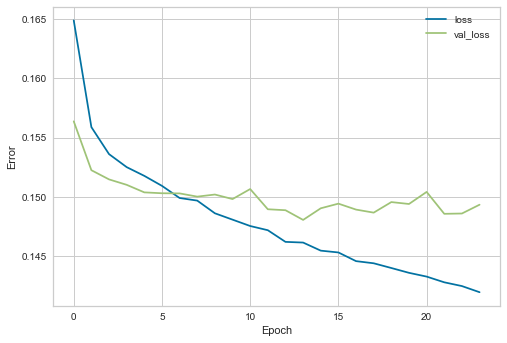

In [126]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [127]:
model_adam_check.evaluate(X_test, y_test, verbose=0)

0.15740430355072021

Adding regularizer in order to decrease overfitting

In [128]:
from tensorflow.keras import regularizers

In [129]:
def build_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
        layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
        layers.Dense(1)
    ])
    return model

In [130]:
model_regul = build_model()
model_regul = compile_model(model_regul)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
num_epochs = 100
history = model_regul.fit(X_train, y_train, epochs=num_epochs,
                    validation_split = 0.2, verbose=1, 
                    callbacks=[early_stop])

Epoch 1/100
962/962 [==============================] - 2s 2ms/step - loss: 0.2241 - val_loss: 0.1937
Epoch 2/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1827 - val_loss: 0.1722
Epoch 3/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1690 - val_loss: 0.1632
Epoch 4/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1630 - val_loss: 0.1581
Epoch 5/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1604 - val_loss: 0.1570
Epoch 6/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1590 - val_loss: 0.1567
Epoch 7/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1580 - val_loss: 0.1559
Epoch 8/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1579 - val_loss: 0.1553
Epoch 9/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1570 - val_loss: 0.1563
Epoch 10/100
962/962 [==============================] - 1s 2ms/step - loss: 0.1566 - val_lo

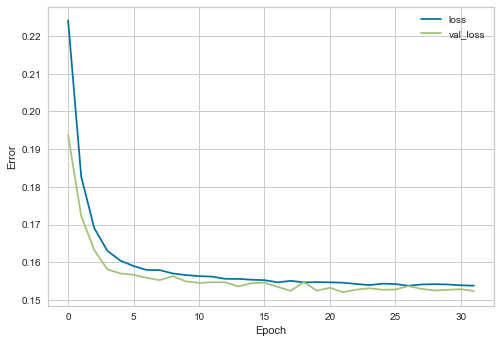

In [131]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [132]:
model_regul.evaluate(X_test, y_test, verbose=0)

0.15423908829689026

We can see that there is not an improvement

We can also try the dropout method to reduce overfitting

In [133]:
def build_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    return model

In [134]:
model_drop = build_model()
model_drop = compile_model(model_drop)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
num_epochs = 100
history = model_drop.fit(X_train, y_train, epochs=num_epochs,
                    validation_split = 0.2, verbose=1, 
                    callbacks=[early_stop])

Epoch 1/100
962/962 [==============================] - 2s 2ms/step - loss: 0.2674 - val_loss: 0.1967
Epoch 2/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1938 - val_loss: 0.1756
Epoch 3/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1772 - val_loss: 0.1647
Epoch 4/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1698 - val_loss: 0.1622
Epoch 5/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1677 - val_loss: 0.1588
Epoch 6/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1669 - val_loss: 0.1588
Epoch 7/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1659 - val_loss: 0.1588
Epoch 8/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1660 - val_loss: 0.1580
Epoch 9/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1661 - val_loss: 0.1581
Epoch 10/100
962/962 [==============================] - 2s 2ms/step - loss: 0.1656 - val_lo

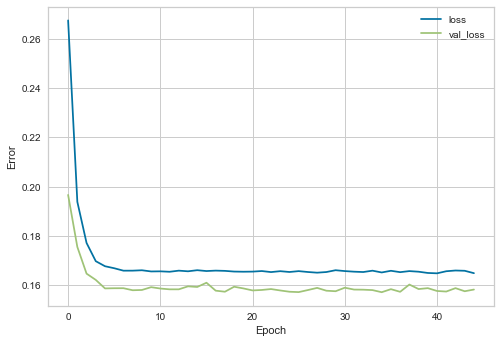

In [135]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

We can see that the val_loss is less than the loss so it is a sign of underfitting

In [136]:
model_drop.evaluate(X_test, y_test, verbose=0)

0.15980397164821625

# Evaluation

Now we need to test our models with the validation dataset 

First, we will evaluate the best Decision Tree method which is Extreme Randomize Tree Regressor

In [137]:
predicted = extremely_rts.predict(independent_val)
mean_absolute_error(predicted, dependent_val)

0.15136640137812246

Now we can evaluate our best Neural Network

In [138]:
model_adam.evaluate(independent_val, dependent_val, verbose=0)

0.15796494483947754

## So our final score with our best model is 0.1513 with the method Extreme Random Forest

We have also seen above that the Extreme Random Forest had a score of almost 0.134 with 20% test dataset.